#Miniproject 3


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score

##Utilities
###Weight Initialization

In [ ]:
def random_initialization(inputs, outputs):
    return np.random.randn(inputs, outputs)*np.sqrt(1. / inputs)

def Xavier_initialization(inputs, outputs):
  return np.random.normal(loc=0.0, scale = np.sqrt(2/(inputs+outputs)), size = (inputs,outputs))



###Loss Functions

In [ ]:
def softmax(z):
  max = np.max(z)
  sigma = np.exp(z) / np.exp(z).sum(axis=-1,keepdims=True)
  return sigma

def SoftmaxCrossEntropy(y_true, y_pred):
    true_vector = y_pred[np.arange(len(y_pred)),y_true]
    CE = - true_vector + np.log(np.sum(np.exp(y_pred),axis=-1))
    return CE

def SoftmaxCrossEntropy_prime(y_true, y_pred):
    one_hot = np.zeros_like(y_pred)               #initialize one hot to size of y_pred (output of last layer)               
    one_hot[np.arange(len(y_pred)),y_true] = 1    #one hot
    sigma = softmax(y_pred)                       #softmax on output of last layer
    CE_prime = (- one_hot + sigma) / y_pred.shape[0]
    return CE_prime

#MSE does not work well for multiclass classification
def mse(y_true, y_pred):
  y_pred = softmax(y_pred)
  loss = np.sum(1/2 * (y_true - y_pred)**2)
  return loss

def mse_prime(y_true, y_pred):
  y_pred = softmax(y_pred)
  derivative = (y_true - y_pred)
  return derivative

###Activation Funtions

In [ ]:
def ReLU(x):
  return np.maximum(0,x)

def ReLU_prime(x):
  x[x<0]=0
  x[x>0]=1
  return x

def tanh(x):
  return np.tanh(x)

def tanh_prime(x):
  return 1-np.tanh(x)**2

def sigmoid(x):
  sigma =  1.0 / (1.0 + np.exp(-x))
  return sigma

def sigmoid_prime(x):
  return sigmoid(x) * (1.0 - sigmoid(x))

##Layers

In [ ]:
#abstract layer class 
class Layer:
  def __init__(self):
    self.input = [] #every layer has an input and an output
    self.output = []
  
  def reset(self): #reset the inputs and outputs after each epoch
    self.input = []
    self.output = []

class ActivationLayer(Layer):
  def __init__(self, activation = ReLU, activation_prime = ReLU_prime):
    super().__init__()
    self.activation_function = activation
    self.activation_function_prime = activation_prime

  def forward(self, z, training = True):
    a = self.activation_function(z) #a = g(z)
    if training:
      self.input.append(z)                          #save the input and output of the layer for backpropagation
      self.output.append(a)                         #skip this step for prediction as it will interfere with prediction done between training batches
    return a

  #chain rule: gradient x derivative wrt z (activation input) 
  def backpropagation(self, input, output_gradient): 
    return output_gradient*self.activation_function_prime(input)


class HiddenLayer(Layer):
  def __init__(self, input_size, output_size, learning_rate, regularization, lambd, weights = random_initialization):
    super().__init__()
    self.learning_rate = learning_rate
    self.weights = weights(input_size, output_size) #initialize weights as random matrix with dims (output of previous layer, neuron count)
    self.bias = np.zeros(output_size)               #bias neuron
    self.grad_weights = None                        #gradient of weights. updated during backpropagation
    self.grad_bias = None                           #gradient of bias. updated during backpropagation
    self.regularization = regularization            #regularization method
    self.lambd = lambd                              #regularization constant
    
  def forward(self,X, training = True):
    z = np.dot(X,self.weights) + self.bias          # z = wX + b
    if training:
      self.input.append(X)                          #save the input and output of the layer for backpropagation
      self.output.append(z)                         #skip this step for prediction as it will interfere with prediction done between training batches
    return z
    
  def set_weights(self, weights):
    self.weights = weights

  def set_bias(self, bias):
    self.bias = bias

  def backpropagation(self,input,output_gradient):
    #chain rule: gradient x weights
    grad_input = np.dot(output_gradient, self.weights.T)
    #chain rule gradient of weights and bias
    self.grad_weights = np.dot(input.T, output_gradient)
    self.grad_bias = output_gradient.mean(axis=0)*input.shape[0]

    #compute derivative of regularization term
    reg_prime = 0
    m = self.weights.shape[1]
    if self.regularization =='l2':
      reg_prime = (self.lambd / m) * self.weights
    elif self.regularization == 'l1':
      reg_prime = (self.lambd / m) * np.sign(self.weights)

    #update weights and bias using gradient descent 
    # w = w - lr (dw - dreg )
    self.weights =  self.weights - self.learning_rate * self.grad_weights - self.learning_rate * reg_prime
    self.bias =  self.bias - self.learning_rate*self.grad_bias
    return grad_input

##Neural Net

In [ ]:
class MLP:
  def __init__(self, input_size = 784, hidden_layers = [], activation = ReLU, 
               activation_prime = ReLU_prime, loss_function = SoftmaxCrossEntropy,
               loss_function_prime = SoftmaxCrossEntropy_prime, learning_rate = 0.1,
               regularization = 'l2', lambd = 0):
    
    self.input_size = input_size                          #size of input
    self.hidden_layers = hidden_layers                    #hidden layer list 
    self.activation_function = activation                 #ReLU, sigmoid, or tanh
    self.activation_function_prime = activation_prime
    self.loss_function = loss_function                    #softmax crossentropy loss
    self.loss_function_prime = loss_function_prime        
    self.learning_rate = learning_rate
    self.regularization = regularization                   #regularization technique or None
    self.lambd = lambd                                     #regularization constant

    def build_network(): #construct the neural network (list of matrices)
      network = []
      depth = len(hidden_layers)
      inputs = self.input_size
      #append hidden layers and activation layers        
      for d in range(depth):
        outputs = self.hidden_layers[d]
        network.append(HiddenLayer(inputs, outputs, learning_rate = self.learning_rate, regularization = self.regularization, lambd = self.lambd))
        network.append(ActivationLayer(self.activation_function, self.activation_function_prime))
        inputs = outputs
      #output layer
      network.append(HiddenLayer(inputs, 10, learning_rate = self.learning_rate, regularization = self.regularization, lambd = self.lambd))
      return network
    self.network = build_network()

  def forward(self, X, training = True):
    #training = True if fit, training = False if predict
    input = X
    for layer in self.network:
      output = layer.forward(input, training = training) 
      input = output                      
    return output 

  def predict(self,X):
    #get output of output layer
    logits = self.forward(X, training = False)
    logits = softmax(logits)
    #get number as index of output with highest probability
    prediction = logits.argmax(axis=1)
    return prediction 

  def fit(self,X,Y):
    # Get the final layer output
    logits = self.forward(X)

    # Compute the loss and the gradient of loss with respect to output of last layer (logits)
    loss = np.mean(self.loss_function(Y, logits))
    loss_gradient = self.loss_function_prime(Y, logits)

    #backpropagate the gradient of the loss through the layers, multiplying by gradient of each layer
    #(chain rule)
    gradient = loss_gradient
    for l in range(len(self.network))[::-1]:  #backwards
      layer = self.network[l]
      gradient = layer.backpropagation(layer.input[0], gradient)
      layer.reset()
    
      #if type(layer).__name__ == 'HiddenLayer':
        #print(layer.weights)
    return loss


In [ ]:
def evaluate_acc(y_prediction, y_test): #return accuracy using prediction and labels
  return np.sum(y_prediction == y_test) / y_test.shape[0] * 100

##TEST SITE
Get MNIST Data

In [ ]:
#importing the MNIST dataset, ~size of 60,000 images, represented by a numpy array of 28x28.
data = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = data.load_data()

#Normalizing the data to be within a unit range
X_train = X_train/255.0
X_test = X_test/255.0
X_train = X_train.reshape(-1,28*28)
X_test = X_test.reshape(-1,28*28)

# normalize = transforms.Compose([transforms.ToTensor(),
#             transforms.Normalize((0.5), (0.5))])

def one_hot_encode(Y):
  encoded = np.zeros((len(Y), 10))
  for i,y in enumerate(Y):
    encoded[i][y] = 1
  return encoded

11493376/11490434 [==============================] - 0s 0us/step


###Quick Test

In [ ]:
hidden_layers = [64,64]                      #list
activation = ReLU                            #ReLU, sigmoid, or tanh
activation_prime = ReLU_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = 'l2'                        # 'l2' , 'l1', or None
lambd = 0.1                                  #play around to see the effects
learning_rate = 0.1

num_epochs = 5
mini_batch_size = 50

#TEST QUICKLY TO ASSIST WITH DEBUGGING
###################################################################################################################################################

DNN = MLP(input_size = X_train.shape[1], hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
          regularization = regularization, lambd = lambd, learning_rate = learning_rate)

losses = []
n=100
i,j = 0, n
for epoch in range(20):
  loss = DNN.fit(X_train[i:j],Y_train[i:j])
  losses.append(loss)
  i += n
  j += n

In [ ]:
#Accuracy > 20% typically indicates strong performance using minibatch
#Typical accuracies for good network using this training method between [50, 80]

predictions = DNN.predict(X_test[:100])
accuracy = evaluate_acc(predictions, Y_test[:100])
accuracy

44.0

##Mini-Batch Testing

In [ ]:
from tqdm import trange
def load_minibatches(X, Y, batch_size = 50, shuffle=False):
  for i in trange(0, len(X) - batch_size + 1, batch_size):
    if shuffle:
      indices = np.random.permutation(len(X))
      batch = indices[i:i + batch_size]
    else:
      batch = slice(i, i + batch_size)
    yield X[batch], Y[batch]

###Train and Predict

In [ ]:
#Minibatch training. Expect accuracy > 90%. If 2+ layers, accuracy  > 97%

hidden_layers = [64, 64]                       #list
activation = ReLU                            #ReLU, sigmoid, or tanh
activation_prime = ReLU_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = None                        # 'l2' , 'l1', or None
lambd = 0                                 #play around to see the effects
learning_rate = 0.1


num_epochs = 5                               #performance converges as number of epochs increases
mini_batch_size = 50                         #mini batch size is a hyperparameter for training

##################################################################################################################################################
def train_and_predict(hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
                      regularization = regularization, lambd = lambd, learning_rate = learning_rate):
  DNN = MLP(input_size = X_train.shape[1], hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
            regularization = regularization, lambd = lambd, learning_rate = learning_rate)

  losses, acc, train_acc, timing = [], [], [], []

  #train over epochs
  for epoch in range(num_epochs):
    l = []
    start = time.time()
    #train using minibatch
    for x_batch,y_batch in load_minibatches(X_train, Y_train, batch_size=mini_batch_size, shuffle=True):
      loss = DNN.fit(x_batch,y_batch)
      l.append(loss)
    losses.append(np.mean(l))
    #get test and training accuracy for each epoch
    test_predictions = DNN.predict(X_test)
    train_predictions = DNN.predict(X_train[:500])
    timing.append(time.time() - start)
    acc.append(evaluate_acc(test_predictions, Y_test))
    train_acc.append(evaluate_acc(train_predictions, Y_train[:500]))

  #get the final test and training accuracy
  predictions = DNN.predict(X_test)
  accuracy = evaluate_acc(predictions, Y_test)
  print(f'\nTest Accuracy: {accuracy}%')

  predictions = DNN.predict(X_train[:1000])
  accuracy = evaluate_acc(predictions, Y_train[:1000])
  print(f'\nTrain Accuracy: {accuracy}%')

  #plot_results
  epochs = [x for x in range(len(losses))] 
  fig = plt.figure(figsize= (20,10))
  fig.add_subplot(331)
  plt.plot(epochs, losses)
  plt.xlabel('Epoch'), plt.ylabel('Cross Entropy Loss')
  plt.title('Neural Network Loss During Training')

  fig.add_subplot(332)
  plt.plot(epochs,acc, label = 'Test Accuracy')
  plt.plot(epochs,train_acc, label = 'Train Accuracy')
  plt.xlabel('Epoch'), plt.ylabel('Performance')
  plt.title('Neural Network Performance During Training')
  plt.legend()

  fig.add_subplot(333)
  plt.plot(epochs, timing)
  plt.xlabel('Epoch'), plt.ylabel('Time (s)')
  plt.title('Neural Network Training (time)')

  fig.tight_layout(rect=[0.03, 0.03, 0.8, 0.97])

  plt.show()


#TESTS

**Test 1:** No Hidden Layers

100%|██████████| 1200/1200 [00:04<00:00, 271.80it/s]



Test Accuracy: 97.02%

Train Accuracy: 97.3%


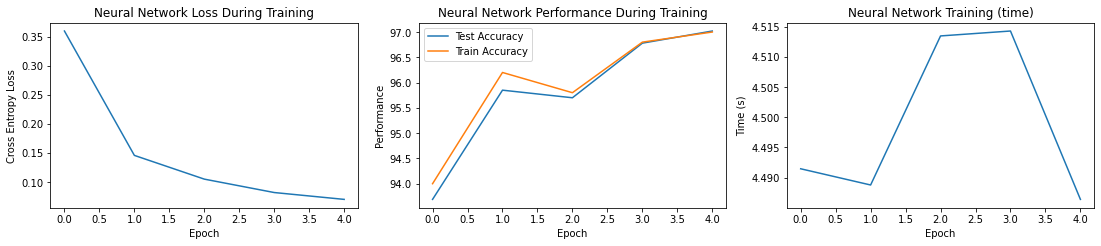

In [ ]:
hidden_layers = [64,64]                          #list
activation = ReLU                            #ReLU, sigmoid, or tanh
activation_prime = ReLU_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = None                        # 'l2' , 'l1', or None
lambd = 0                                 #play around to see the effects
learning_rate = 0.1

num_epochs = 5                               #performance converges as number of epochs increases
mini_batch_size = 50                         #mini batch size is a hyperparameter for training

train_and_predict(hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
                      regularization = regularization, lambd = lambd, learning_rate = learning_rate)

**Test 2:** 1 Hidden Layer with 128 neurons, ReLU activation

100%|██████████| 1200/1200 [00:05<00:00, 213.63it/s]



Test Accuracy: 97.87%

Train Accuracy: 99.2%


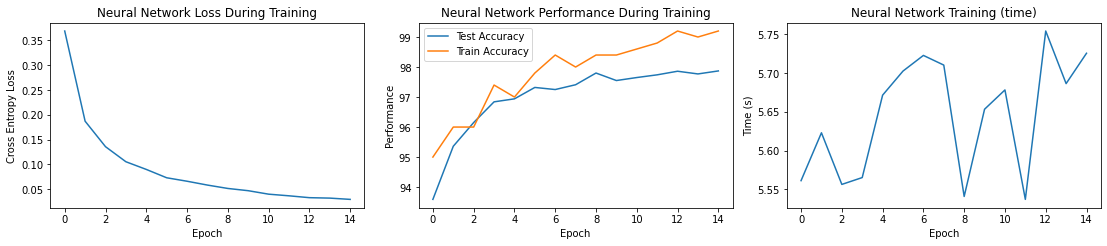

In [ ]:
hidden_layers = [128]                          #list
activation = ReLU                            #ReLU, sigmoid, or tanh
activation_prime = ReLU_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = None                        # 'l2' , 'l1', or None
lambd = 0                                 #play around to see the effects
learning_rate = 0.1

num_epochs = 15                               #performance converges as number of epochs increases
mini_batch_size = 50                         #mini batch size is a hyperparameter for training

train_and_predict(hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
                      regularization = regularization, lambd = lambd, learning_rate = learning_rate)

**Test 3:** 2 Hidden Layer with 128 neurons each, ReLU activation

100%|██████████| 1200/1200 [00:06<00:00, 185.97it/s]



Test Accuracy: 98.07000000000001%

Train Accuracy: 99.7%


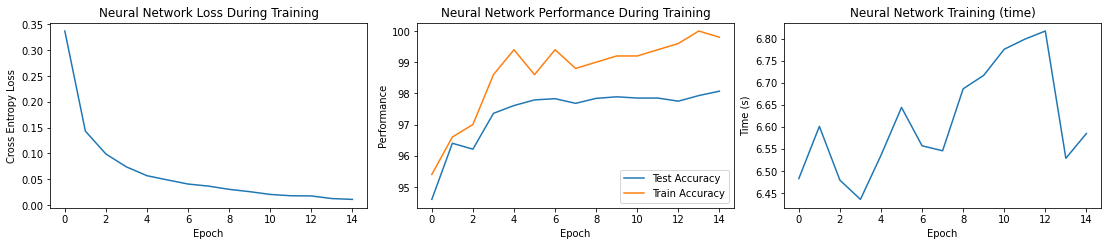

In [ ]:
hidden_layers = [128, 128]                          #list
activation = ReLU                            #ReLU, sigmoid, or tanh
activation_prime = ReLU_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = None                        # 'l2' , 'l1', or None
lambd = 0                                 #play around to see the effects
learning_rate = 0.1

num_epochs = 15                               #performance converges as number of epochs increases
mini_batch_size = 50                         #mini batch size is a hyperparameter for training

train_and_predict(hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
                      regularization = regularization, lambd = lambd, learning_rate = learning_rate)

**Test 4:** 2 Hidden Layer with 128 neurons each, sigmoid activation

100%|██████████| 1200/1200 [00:07<00:00, 154.91it/s]



Test Accuracy: 96.35000000000001%

Train Accuracy: 96.7%


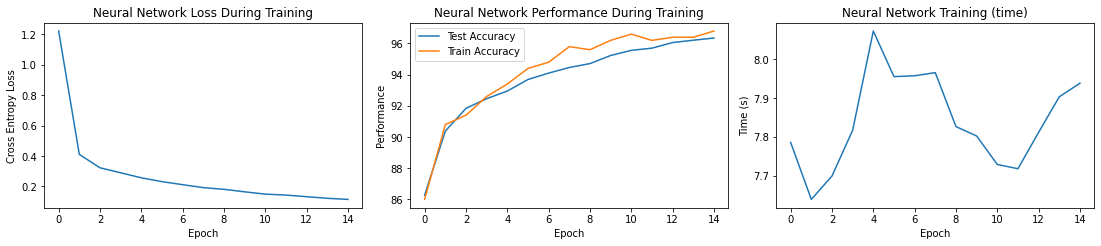

In [ ]:
hidden_layers = [128, 128]                          #list
activation = sigmoid                            #ReLU, sigmoid, or tanh
activation_prime = sigmoid_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = None                        # 'l2' , 'l1', or None
lambd = 0                                 #play around to see the effects
learning_rate = 0.1

num_epochs = 15                               #performance converges as number of epochs increases
mini_batch_size = 50                         #mini batch size is a hyperparameter for training

train_and_predict(hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
                      regularization = regularization, lambd = lambd, learning_rate = learning_rate)

**Test 5:** 2 Hidden Layer with 128 neurons each, tanh activation

100%|██████████| 1200/1200 [00:07<00:00, 156.80it/s]



Test Accuracy: 97.87%

Train Accuracy: 99.8%


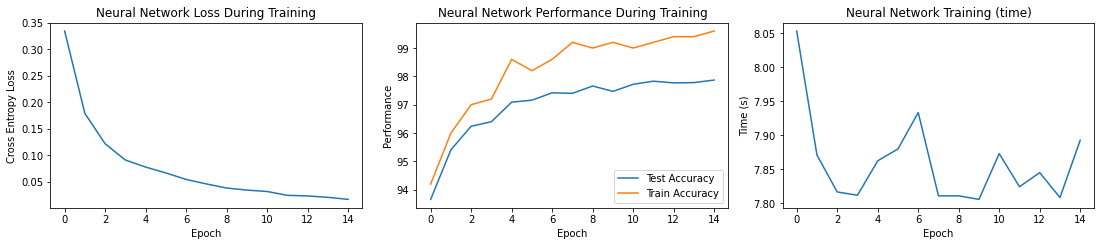

In [ ]:
hidden_layers = [128, 128]                          #list
activation = tanh                            #ReLU, sigmoid, or tanh
activation_prime = tanh_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = None                        # 'l2' , 'l1', or None
lambd = 0                                 #play around to see the effects
learning_rate = 0.1

num_epochs = 15                               #performance converges as number of epochs increases
mini_batch_size = 50                         #mini batch size is a hyperparameter for training

train_and_predict(hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
                      regularization = regularization, lambd = lambd, learning_rate = learning_rate)

**Test 6:** 2 Hidden Layer with 128 neurons each, ReLU activation, L2 regularization with lambda = 0.1

100%|██████████| 1200/1200 [00:06<00:00, 172.73it/s]



Test Accuracy: 97.42%

Train Accuracy: 98.2%


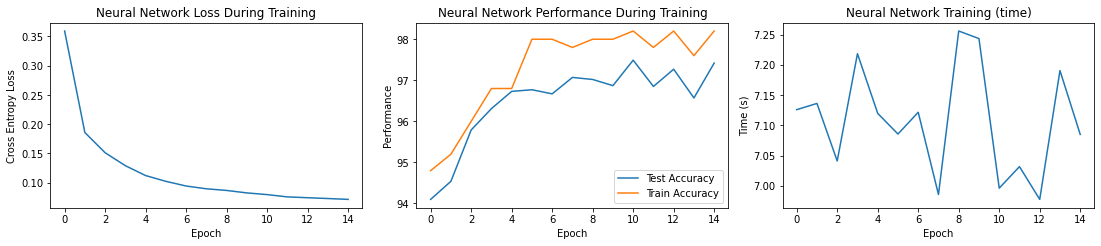

In [ ]:
hidden_layers = [128, 128]                          #list
activation = ReLU                            #ReLU, sigmoid, or tanh
activation_prime = ReLU_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = 'l2'                        # 'l2' , 'l1', or None
lambd = 0.1                               #play around to see the effects
learning_rate = 0.1

num_epochs = 15                               #performance converges as number of epochs increases
mini_batch_size = 50                         #mini batch size is a hyperparameter for training

train_and_predict(hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
                      regularization = regularization, lambd = lambd, learning_rate = learning_rate)

**Test 7:** 2 Hidden Layer with 128 neurons each, ReLU activation

  0%|          | 0/1200 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 1200/1200 [00:06<00:00, 194.74it/s]



Test Accuracy: 9.8%

Train Accuracy: 9.700000000000001%


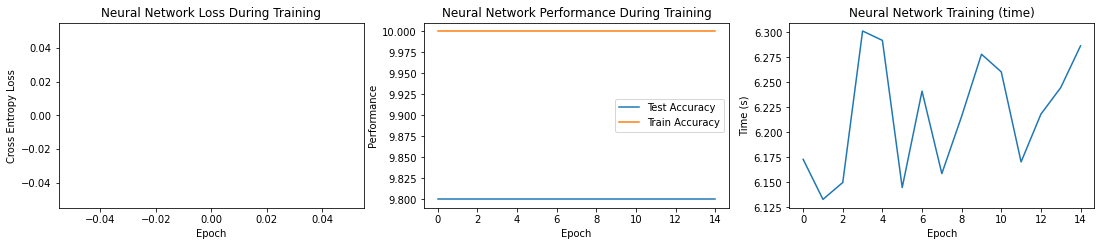

In [ ]:
hidden_layers = [128, 128]                          #list
activation = ReLU                            #ReLU, sigmoid, or tanh
activation_prime = ReLU_prime                #ReLU_prime, sigmoid_prime, tanh_prime
regularization = None                        # 'l2' , 'l1', or None
lambd = 0                               #play around to see the effects
learning_rate = 0.1

num_epochs = 15                               #performance converges as number of epochs increases
mini_batch_size = 50                         #mini batch size is a hyperparameter for training

#Un-normalize data
(X_train, Y_train), (X_test, Y_test) = data.load_data()
X_train = X_train.reshape(-1,28*28)
X_test = X_test.reshape(-1,28*28)


train_and_predict(hidden_layers = hidden_layers, activation = activation, activation_prime = activation_prime,
                      regularization = regularization, lambd = lambd, learning_rate = learning_rate)


#Renormalize data
(X_train, Y_train), (X_test, Y_test) = data.load_data()
X_train = X_train/255.0
X_test = X_test/255.0
X_train = X_train.reshape(-1,28*28)
X_test = X_test.reshape(-1,28*28)

##Performance Comparison to Convolutional Neural Network

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#Normalizing data so that entries are in range [-0.5, 0.5]
normalize = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))])

train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=normalize)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=normalize)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=False)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
#CNN Architecture 
class CNN(nn.Module):
  def __init__(self):
    '''
    CNN Constructor
    '''
    super(CNN, self).__init__() 
    self.conv1 = nn.Conv2d(1, 32, 3)  #Convolutionary layer with 32 kernels of size 3x3
    self.conv2 = nn.Conv2d(32, 64, 3) #Convolutionary layer with 64 kernels of size 3x3
    self.pool = nn.MaxPool2d(2, 2)    #Max pool layer with kernels of size 2x2
    self.conv3 = nn.Conv2d(64, 64, 3) #Convolutionary layer with 64 kernels of size 3x3
    self.conv4 = nn.Conv2d(64, 64, 3) #Convolutionary layer with 64 kernels of size 3x3
    self.fc1 = nn.Linear(64*8*8, 10)  #Linear layer with output of size 10


  def forward(self, x):
    a0 = x #Layer 0 is made of features (vector of length 4096)
    a1 = self.conv1(a0) #Layer 0 convoluted 
    a1 = F.relu(a1)     #Layer 1 is RELU activations of convolutions
    a2 = self.conv2(a1) #Layer 1 is convoluted 
    a2 = F.relu(a2)     #Layer 2 is RELU activations of convolutions
    a2 = self.pool(a2)  #Max pooling on layer 2
    a3 = self.conv3(a2) #Layer 2 is convoluted 
    a3 = F.relu(a3)     #Layer 3 is RELU activations of convolutions
    a4 = self.conv4(a3) #Layer 3 is convoluted 
    a4 = F.relu(a4)     #Layer 3 is RELU activations of convolutions
    a4 = a4.view(-1, 64*8*8) #Flattening layer
    a5 = self.fc1(a4)   #Linear layer
    h = a5              #Hypothesis
    return h

In [ ]:
#using GPU runtime

net = CNN()
start = time.time()

criteron = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)


net = CNN()
start = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

e_count = 5  # loop over the dataset 10 times
for epoch in range(e_count): 
    print(f'Epoch: {epoch}') 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
finish = time.time()
print('Finished Training') 
print('Training time for {} epochs: {} m {} s'.format(e_count, int((finish-start)/60),int((finish-start)%60)))


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Finished Training
Training time for 5 epochs: 11 m 25 s


In [ ]:
#Predicts labels of the test images using the above trained CNN. Measure
#and display classification accuracy.

_, predicted = torch.max(outputs, 1)
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Training over {} epochs'.format(e_count))
print('Total Correct:', correct)
print('Total Tested:', total)
print('Accuracy of the network on the {} test images: {}%'.format(total,100*correct/total))

Training over 5 epochs
Total Correct: 9863
Total Tested: 10000
Accuracy of the network on the 10000 test images: 98.63%


In [ ]:
print(net)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4096, out_features=10, bias=True)
)
